# Проект

### Описание проекта
Дан стартап, который продаёт продукты питания. 
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

### Цели и задачи исследования:
- Разобраться, как ведут себя пользователи мобильного приложенияю. Изучить воронку продаж и узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Выясните, какой шрифт лучше.

### Описание данных

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### 1. Загрузка данных и подготовка к анализу

In [1]:
# Библиотеки
import pandas as pd
import numpy as np
from numpy import arange
from datetime import datetime, date, time
from IPython.display import display 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats import weightstats as stestsztest
from tqdm import tqdm
import warnings as warning
warning.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

### 2. Подготовка данных

In [3]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# Долой заглавные из названий столбцов
data.columns = ['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id']
data.columns

Index(['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id'], dtype='object')

In [5]:
data['event_time_stamp'] = pd.to_datetime(data['event_time_stamp'], unit = 's')
data['date'] = data['event_time_stamp'].dt.date
data.info()
display(data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  int64         
 2   event_time_stamp  244126 non-null  datetime64[ns]
 3   exp_id            244126 non-null  int64         
 4   date              244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


,event_name,device_id_hash,event_time_stamp,exp_id,date
111517,OffersScreenAppear,4610257715841762748,2019-08-04 06:34:45,248,2019-08-04
125644,PaymentScreenSuccessful,5151218799456449998,2019-08-04 13:17:55,247,2019-08-04
11759,OffersScreenAppear,5563901287895361556,2019-08-01 09:15:19,248,2019-08-01
55850,MainScreenAppear,7179210912513448739,2019-08-02 12:13:40,248,2019-08-02
126372,MainScreenAppear,2928246415014807834,2019-08-04 13:41:40,246,2019-08-04


In [6]:
data.duplicated().sum()

413

In [7]:
data.drop_duplicates().reset_index(drop=True).head()

,event_name,device_id_hash,event_time_stamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### 3. Изучение и проверка данных

#### 3.1. Количество событий в логе

In [8]:
print('Количество событий в логе', data['event_name'].nunique())

Количество событий в логе 5


##### Выводы

В логе всего 5 событий

#### 3.2. Количество пользователей в логе

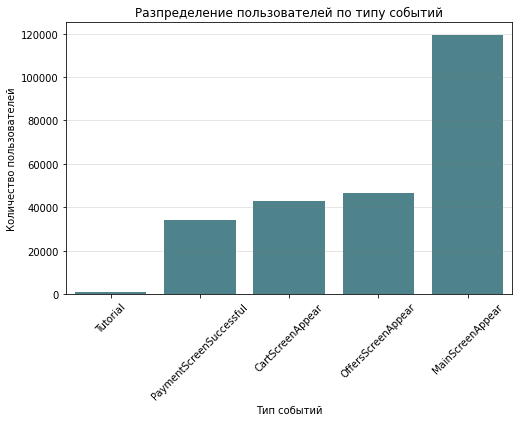

In [9]:
user_number = data.groupby('event_name')[['device_id_hash']].count().reset_index().sort_values(by = 'device_id_hash')
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=user_number, x='event_name', y='device_id_hash', ax=ax, color='#448A96')
ax.set_title('Разпределение пользователей по типу событий')
ax.set_xlabel('Тип событий')
ax.set_ylabel('Количество пользователей')
ax.grid(color='grey', alpha=0.25, axis='y')
ax.set_xticklabels(labels=user_number['event_name'],fontdict={'fontsize': 10}, rotation=45)
None

##### Выводы

Самым популярным событием является `MainScreenAppear`, самым редким посещение страницы `Tutorial`

#### 3.3. Среднее количество событий приходится на пользователя?

In [10]:
user_event_name = data.groupby('device_id_hash')['event_name'].count()
print('Среднее количество событий приходится на пользователя', user_event_name.mode())

Среднее количество событий приходится на пользователя 0    5
dtype: int64


##### Выводы

Поскольку данные  по количеству событий неоднородные и имееют достаточно резкие перепады, для определения среднего количества возьмем моду. На одного пользователя приходится около 5 событий.

In [11]:
print('Среднее арифметическое количество событий приходится на пользователя', user_event_name.mean())
print('Среднее медианное количество событий приходится на пользователя', user_event_name.median())
print('минимальное количество событий приходится на пользователя', user_event_name.min())
print('максимальное количество событий приходится на пользователя', user_event_name.max())

Среднее арифметическое количество событий приходится на пользователя 32.33028737915508
Среднее медианное количество событий приходится на пользователя 20.0
минимальное количество событий приходится на пользователя 1
максимальное количество событий приходится на пользователя 2308


#### 3.4.  Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [12]:
print('Исходные данные получены за период', data['date'].min(), '-',data['date'].max())

Исходные данные получены за период 2019-07-25 - 2019-08-07


In [13]:
time = data.groupby('event_time_stamp', as_index = False)['device_id_hash'].count()
time = time.rename(columns = {'device_id_hash':'numb'})
time.head()

,event_time_stamp,numb
0,2019-07-25 04:43:36,1
1,2019-07-25 11:11:42,1
2,2019-07-25 11:28:47,2
3,2019-07-25 11:48:42,1
4,2019-07-25 11:48:43,1


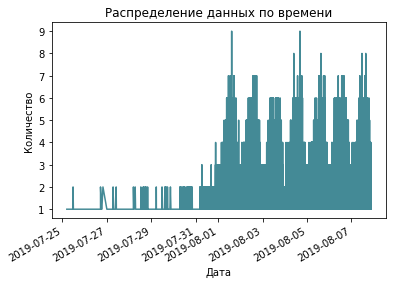

In [14]:
fig, ax = plt.subplots()
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.title('Распределение данных по времени')
plt.plot(time['event_time_stamp'], time['numb'], color='#448A96')
fig.autofmt_xdate()
None

In [15]:
df_viz = data\
    .assign(ts_hours = data['event_time_stamp'].astype('datetime64[h]'))\
    .groupby('ts_hours', as_index=False)\
    .agg({'device_id_hash': 'nunique'})\
    .sort_values(by='ts_hours')
df_viz

,ts_hours,device_id_hash
0,2019-07-25 04:00:00,1
1,2019-07-25 11:00:00,3
2,2019-07-25 14:00:00,1
3,2019-07-25 20:00:00,2
4,2019-07-26 03:00:00,1
...,...,...
279,2019-08-07 17:00:00,383
280,2019-08-07 18:00:00,323
281,2019-08-07 19:00:00,277
282,2019-08-07 20:00:00,175


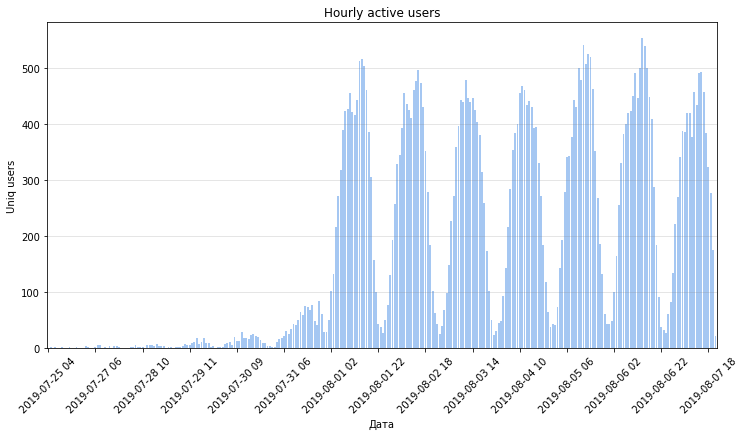

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_viz, x='ts_hours', y='device_id_hash', ax=ax, color='#98C6FF')
ax.set_title('Hourly active users')
ax.set_xticks(ticks=[*range(len(df_viz['ts_hours']))][::20])
ax.set_xticklabels(labels=df_viz['ts_hours'].dt.strftime('%Y-%m-%d %H').to_list()[::20], 
                   fontdict={'fontsize': 10}, rotation=45)
ax.set_xlabel('Дата')
ax.set_ylabel('Uniq users')
ax.grid(color='grey', alpha=0.25, axis='y')

##### Выводы

Судя по графику в месте резкого скачка находится граница неполных и полных данных. Для дальнейшего анализа возьмем период полных данных с 2019-08-01 по 2019-08-07

#### 3.5. Сколько событий и пользователей потеряли, отбросив старые данные?

In [17]:
data_loss = data[data['event_time_stamp'] < '2019-08-01']
print('Количество потерянных событий', data_loss['event_name'].count())
print('Количество потерянных пользователей', data_loss['event_name'].nunique())

Количество потерянных событий 2828
Количество потерянных пользователей 5


##### Выводы

В отсеяные данные попали 2828 событий и 5 пользователей

#### 3.6. Проверьте, наличие пользователей из всех трёх экспериментальных групп.

In [18]:
data_clear = data[data['event_time_stamp'] >= '2019-08-01']
display(data_clear.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

##### Выводы

В каждой из трех групп присутствуют пользователи:
- в 246 группе 2484 пользователя
- в 247 группе 2513 пользователя
- в 248 группе 2537 пользователя

### 4. Изучение воронки событий

#### 4.1. Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [19]:
print(data_clear['event_name'].value_counts())

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64


##### Выводы

Типы событий в логах:
- `MainScreenAppear`
- `PaymentScreenSuccessful`
- `CartScreenAppear`
- `OffersScreenAppear`
- `Tutorial`

Чаще всего встречается  `MainScreenAppear`, самым редким событием является `Tutorial`.

#### 4.2. Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [20]:
event_users = data_clear.groupby('event_name')[['device_id_hash']].nunique().sort_values(by='device_id_hash', ascending = False)
event_users['user_share'] = round(event_users['device_id_hash']/data_clear['device_id_hash'].nunique(), 3)
event_users

,device_id_hash,user_share
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


In [21]:
total_id = data_clear.groupby('device_id_hash')[['event_name']].nunique()

id_event = total_id.query('event_name ==5')
print('Доля пользователей, которые хоть раз совершали все события {:.2f}%'\
      .format(id_event['event_name'].count()*100/data_clear['device_id_hash'].nunique()))

Доля пользователей, которые хоть раз совершали все события 6.19%


##### Выводы

Доля пользователей, которые хоть раз совершали все события 6.19%

Доля пользователей, которые хоть раз совершали событие:

<img align="left" width="350" height="350" src="http://joxi.ru/MAj6NLMikJ95DA.jpg">

In [22]:
data_clear['device_id_hash'].nunique()

7534

#### 4.3. Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Порядок событий:
1. `MainScreenAppear` 
2. `OffersScreenAppear` 
3. `CartScreenAppear`
4. `PaymentScreenSuccessful`

Событие `Tutorial` может произойти в любой момент нахождения пользователя на сайте, поэтому в последовательность оно не вписывается и не будет учитываться при расчете воронки.

#### 4.4. По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [23]:
funnel = data_clear.query('event_name != "Tutorial"').pivot_table(
    index='device_id_hash', columns='event_name', values='date', aggfunc='min'
) 
funnel.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
device_id_hash,,,,
6888746892508752,NaN,2019-08-06,NaN,NaN
6909561520679493,2019-08-06,2019-08-06,2019-08-06,2019-08-06
6922444491712477,2019-08-04,2019-08-04,2019-08-04,2019-08-04
7435777799948366,NaN,2019-08-05,NaN,NaN
7702139951469979,2019-08-02,2019-08-01,2019-08-01,2019-08-02


In [24]:
# Считаем воронку
n_main = funnel[~funnel['MainScreenAppear'].isna()].shape[0]
n_offers = funnel[~funnel['OffersScreenAppear'].isna()].shape[0]
n_cart = funnel[~funnel['CartScreenAppear'].isna()].shape[0]
n_payment = funnel[~funnel['PaymentScreenSuccessful'].isna()].shape[0]

In [25]:
print('Посетителей:', n_main)
print('Перешли на страницу с товарами:', n_offers)
print('Добавили товар в корзину:', n_cart)
print('Оплатили заказ:', n_payment)

Посетителей: 7419
Перешли на страницу с товарами: 4593
Добавили товар в корзину: 3734
Оплатили заказ: 3539


In [26]:
print('Конверсия перехода на страницу с товарами:', round(n_offers/n_main, 2))
print('Конверсия перехода в корзину:', round(n_cart/n_offers, 2))
print('Конверсия оплаты заказа:', round(n_payment/n_cart, 2))

Конверсия перехода на страницу с товарами: 0.62
Конверсия перехода в корзину: 0.81
Конверсия оплаты заказа: 0.95


#### 4.5. На каком шаге теряете больше всего пользователей?

Самая большая потеря пользователей в 38% происходит на этапе перехода со стартовой страницы(`MainScreenAppear`) на страницу товара(`OffersScreenAppear`)

#### 4.6. Какая доля пользователей доходит от первого события до оплаты?

In [27]:
print('Доля пользователей доходящих от первого события до оплаты:', round(n_payment/n_main, 2))

Доля пользователей доходящих от первого события до оплаты: 0.48


In [28]:
data_clear\
    .query("event_name != 'Tutorial'")\
    .groupby('event_name', as_index=False)\
    .agg({'device_id_hash': 'nunique'})\
    .sort_values(by='device_id_hash', ascending=False)\
    .assign(cr=lambda row: row['device_id_hash'] / row['device_id_hash'].shift())

,event_name,device_id_hash,cr
1,MainScreenAppear,7419,NaN
2,OffersScreenAppear,4593,0.619086
0,CartScreenAppear,3734,0.812976
3,PaymentScreenSuccessful,3539,0.947777


###  5. Изучите результаты эксперимента

####  5.1. Сколько пользователей в каждой экспериментальной группе?

In [29]:
display(data_clear.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

##### Выводы

- В 246 группе 2484 пользователя
- В 247 группе 2513 пользователя
- В 248 группе 2537 пользователей

####  5.2. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247. 

In [30]:
# Посещенные страницы для каждого пользователя 
a_a_screen = data_clear.groupby(['exp_id', 'device_id_hash', 'event_name'])[['event_name']].count()
a_a_screen.columns = ['numb']
a_a_screen = a_a_screen.reset_index().sort_values(by = 'device_id_hash')
a_a_screen.head(10)

,exp_id,device_id_hash,event_name,numb
0,246,6888746892508752,MainScreenAppear,1
6737,247,6909561520679493,MainScreenAppear,2
6738,247,6909561520679493,OffersScreenAppear,1
6739,247,6909561520679493,PaymentScreenSuccessful,1
6736,247,6909561520679493,CartScreenAppear,1
1,246,6922444491712477,CartScreenAppear,8
2,246,6922444491712477,MainScreenAppear,19
3,246,6922444491712477,OffersScreenAppear,12
4,246,6922444491712477,PaymentScreenSuccessful,8
13411,248,7435777799948366,MainScreenAppear,6


In [31]:
# A-A на примере страницы MainScreenAppear
a_a_main_246 = a_a_screen.query('event_name == "MainScreenAppear"').query('exp_id == 246')
a_a_main_247 = a_a_screen.query('event_name == "MainScreenAppear"').query('exp_id == 247')

Гипотезы:
- H0: Доли групп одинаковые 
- H1: Доли групп разные

In [32]:
users = np.array([len(a_a_main_246), len(a_a_main_247)])
numbs = np.array([a_a_main_246['numb'].sum(), a_a_main_247['numb'].sum()])
stat, pval = proportions_ztest(users, numbs)
print('p-value {0:0.2f}'.format(pval))
if pval<0.05:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-value 0.34
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Выводы

A/A тестом проводилась проверка находят ли статистические критерии разницу между выборками 246 и 247. Для теста были взяты данные по самой посещаемой странице `MainScreenAppear`. Для проверки гипотезы используется Z-тест. Тест не нашел разницы между выборками, p-value больше критической значимости(0.05) и равно 0.34.

####  5.3. Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [33]:
# Кол-во пользователей
total_device_id = a_a_screen['device_id_hash'].nunique()
total_device_id

7534

In [34]:
print('Доля пользователей, посетивших страницу в 246 группе', 
      round((a_a_main_246['device_id_hash'].count() / total_device_id),3))
print('Доля пользователей, посетивших страницу в 247 группе', 
      round((a_a_main_247['device_id_hash'].count() / total_device_id),3))

Доля пользователей, посетивших страницу в 246 группе 0.325
Доля пользователей, посетивших страницу в 247 группе 0.329


In [35]:
event = ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Функция проверки стат. значимости и доли
def z_test(screen, group1, group2, group_data):
    print()
    print('Страница ', screen)
    a_a_1 = group_data.query('event_name == @screen').query('exp_id == @group1')
    a_a_2 = group_data.query('event_name == @screen').query('exp_id == @group2')
    ztest ,pval = stestsztest.ztest(a_a_1['numb'], a_a_2['numb'], value=0,alternative='two-sided')
    print('p-value ', round(pval, 2))
    
    alpha = 0.05 # уровень значимости
    if pval < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
    print('Доля пользователей, посетивших страницу в ', group1, 'группе', 
      round((a_a_1['device_id_hash'].count() / total_device_id),3))
    print('Доля пользователей, посетивших страницу в ', group2, 'группе', 
      round((a_a_2['device_id_hash'].count() / total_device_id),3))
    print()

Гипотезы:
- H0: Доли групп одинаковые 
- H1: Доли групп разные

In [36]:
def event_group(group1, group2, group_data):
    for s in event:
        z_test(s, group1, group2, group_data)
event_group(246, 247, a_a_screen)


Страница  OffersScreenAppear
p-value  0.41
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.205
Доля пользователей, посетивших страницу в  247 группе 0.202


Страница  CartScreenAppear
p-value  0.27
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.168
Доля пользователей, посетивших страницу в  247 группе 0.164


Страница  PaymentScreenSuccessful
p-value  0.38
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.159
Доля пользователей, посетивших страницу в  247 группе 0.154



##### Выводы

Самым популярным событием является посещение страницы `MainScreenAppear`, статистическая значимость для этой страницы посчитана в пункте 5.2. Доля пользователей, посетивших страницу в 246 группе 0.325, в 247 группе 0.329.
Для всех остальных событий z-тест подтвердил нулевую гепотизу о ранстве долей 246 и 247 группы.
Доли пользователей по группам и страницам выглядит следующим образом:
- на странице OffersScreenAppear доля 246 группы 0.205, 247 группы 0.202
- на странице CartScreenAppear доля 246 группы 0.168, 247 группы 0.164
- на странице PaymentScreenSuccessful  доля 246 группы 0.159, 247 группы 0.154

####  5.4. Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [37]:
event = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

In [38]:
event_group(246, 248, a_a_screen)


Страница  MainScreenAppear
p-value  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница
Доля пользователей, посетивших страницу в  246 группе 0.325
Доля пользователей, посетивших страницу в  248 группе 0.331


Страница  OffersScreenAppear
p-value  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.205
Доля пользователей, посетивших страницу в  248 группе 0.203


Страница  CartScreenAppear
p-value  0.65
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.168
Доля пользователей, посетивших страницу в  248 группе 0.163


Страница  PaymentScreenSuccessful
p-value  0.82
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246 группе 0.159
Доля пользователей, посетивших страницу в  248 группе 0.157



In [39]:
event_group(247, 248, a_a_screen)


Страница  MainScreenAppear
p-value  0.3
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  247 группе 0.329
Доля пользователей, посетивших страницу в  248 группе 0.331


Страница  OffersScreenAppear
p-value  0.26
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  247 группе 0.202
Доля пользователей, посетивших страницу в  248 группе 0.203


Страница  CartScreenAppear
p-value  0.13
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  247 группе 0.164
Доля пользователей, посетивших страницу в  248 группе 0.163


Страница  PaymentScreenSuccessful
p-value  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  247 группе 0.154
Доля пользователей, посетивших страницу в  248 группе 0.157



In [40]:
a_a_screen_union = a_a_screen
a_a_screen_union['exp_id'] = a_a_screen_union['exp_id'].astype('str')
a_a_screen_union = a_a_screen_union.replace('246', '246-247').replace('247', '246-247')
a_a_screen_union

,exp_id,device_id_hash,event_name,numb
0,246-247,6888746892508752,MainScreenAppear,1
6737,246-247,6909561520679493,MainScreenAppear,2
6738,246-247,6909561520679493,OffersScreenAppear,1
6739,246-247,6909561520679493,PaymentScreenSuccessful,1
6736,246-247,6909561520679493,CartScreenAppear,1
...,...,...,...,...
6734,246-247,9220879493065341500,OffersScreenAppear,1
6732,246-247,9220879493065341500,CartScreenAppear,1
6733,246-247,9220879493065341500,MainScreenAppear,4
6735,246-247,9221926045299980007,MainScreenAppear,7


In [41]:
event_group('246-247', '248', a_a_screen_union)


Страница  MainScreenAppear
p-value  0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246-247 группе 0.654
Доля пользователей, посетивших страницу в  248 группе 0.331


Страница  OffersScreenAppear
p-value  0.06
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246-247 группе 0.406
Доля пользователей, посетивших страницу в  248 группе 0.203


Страница  CartScreenAppear
p-value  0.26
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246-247 группе 0.332
Доля пользователей, посетивших страницу в  248 группе 0.163


Страница  PaymentScreenSuccessful
p-value  0.45
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Доля пользователей, посетивших страницу в  246-247 группе 0.313
Доля пользователей, посетивших страницу в  248 группе 0.157



##### Выводы

При сравнении  отдельных и объединенных контрольных групп с экспериментальной оказалось,  что разница в выборках есть при сравнении контрольной 246 группы с экспериментальной 248. Разница присутствует только в посещениях страницы `MainScreenAppear`, на посещение остальных страниц в частности страницы оплаты `PaymentScreenSuccessful` изменения не влияют.

####  5.5. Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

##### Выводы

Для проверки значимости было принято значение 0.05. Всего произведено 15 тест на выявление статистической значимости между выборками.